<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/InverseLinkPredcition/blob/main/Sparcification_GCN_Regression_UnseenPredcition_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/MOF/InverseLinkPredcition')

Mounted at /content/drive


In [2]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.9 MB/s eta 0:00:00


Number of nodes: 9030
Number of edges: 38555
Data Loaded and Preprocessed Successfully!
Epoch 1/40
181/181 [==============================] - 9s 39ms/step - loss: 8.7770 - mae: 1.9235 - val_loss: 4.4084 - val_mae: 1.2709
Epoch 2/40
181/181 [==============================] - 5s 30ms/step - loss: 5.1712 - mae: 1.3976 - val_loss: 4.2301 - val_mae: 1.2647
Epoch 3/40
181/181 [==============================] - 6s 34ms/step - loss: 4.3969 - mae: 1.2804 - val_loss: 3.5888 - val_mae: 1.1415
Epoch 4/40
181/181 [==============================] - 5s 29ms/step - loss: 3.8557 - mae: 1.1894 - val_loss: 4.0911 - val_mae: 1.2246
Epoch 5/40
181/181 [==============================] - 4s 21ms/step - loss: 3.3511 - mae: 1.1306 - val_loss: 3.8349 - val_mae: 1.1755
Epoch 6/40
181/181 [==============================] - 5s 28ms/step - loss: 3.2822 - mae: 1.0916 - val_loss: 3.5810 - val_mae: 1.1063
Epoch 7/40
181/181 [==============================] - 4s 22ms/step - loss: 3.1589 - mae: 1.0476 - val_loss: 3.5275

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Adjacency matrix saved successfully!


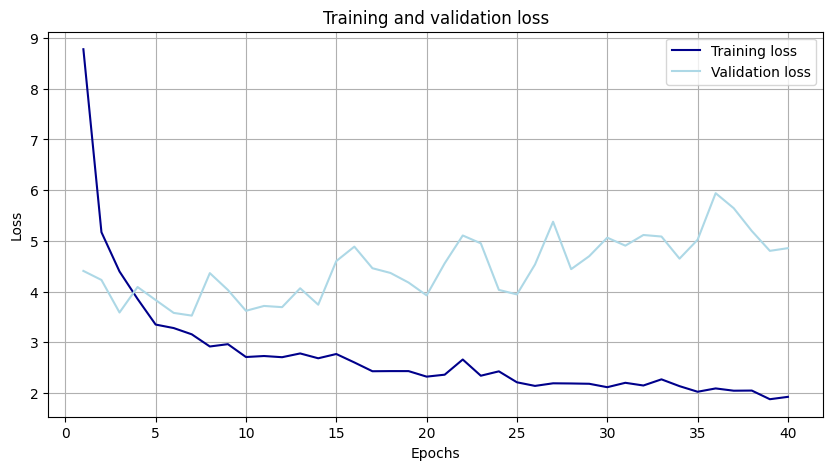

GCN Model Trained and Evaluated Successfully!


In [16]:
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Set seeds for reproducibility
np.random.seed(56)
random.seed(56)
tf.random.set_seed(56)

# Define utility functions
def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

def plot_loss(history):
    # Extract loss from history
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'darkblue', label='Training loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'lightblue', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def preprocess_graph(graph, features):
    # Determine the dimensionality of the feature vectors
    feature_dimension = features.shape[1]

    # Convert the graph to an adjacency matrix
    adjacency_matrix = nx.adjacency_matrix(graph).toarray()

    # Initialize an empty list to store feature vectors
    feature_vectors = []

    # Create a mapping from node labels to integer indices
    node_to_index = {node: index for index, node in enumerate(graph.nodes())}

    # Iterate over nodes in the graph
    for node in graph.nodes():
        # Get the integer index corresponding to the node label
        node_index = node_to_index[node]
        # Check if the node index is valid
        if node_index < len(features):
            # Append the feature vector corresponding to the node index
            feature_vectors.append(features[node_index])
        else:
            # If the node index is out of range, assign a default feature vector
            feature_vectors.append(np.zeros((feature_dimension,)))

    # Convert the list of feature vectors to a numpy array
    feature_matrix = np.array(feature_vectors)

    return adjacency_matrix, feature_matrix

def build_gcn_model(input_shape_feature, input_shape_adjacency):
    # Define input layers
    x_inp_feature = Input(shape=(input_shape_feature,))
    x_inp_adjacency = Input(shape=(input_shape_adjacency,))

    # Define GCN layers for feature input
    x_feature = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x_inp_feature)
    x_feature = Dropout(0.5)(x_feature)
    x_feature = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x_feature)
    x_feature = Dropout(0.5)(x_feature)

    # Define GCN layers for adjacency input
    x_adjacency = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x_inp_adjacency)
    x_adjacency = Dropout(0.5)(x_adjacency)
    x_adjacency = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x_adjacency)
    x_adjacency = Dropout(0.5)(x_adjacency)

    # Concatenate feature and adjacency outputs
    x = concatenate([x_feature, x_adjacency])

    # Adding more hidden layers for better representation learning
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)

    # Output layer
    output = Dense(1, activation='linear')(x)  # Regression output

    # Create model
    model = Model(inputs=[x_inp_feature, x_inp_adjacency], outputs=output)

    # Using a smaller learning rate
    optimizer = Adam(learning_rate=0.001)

    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])  # Use appropriate loss and metrics for regression

    return model
def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])
def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros((1024,), dtype=float)  # Return an array of zeros if molecule can't be parsed
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024), dtype=float)
    except Exception as e:
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,), dtype=float)  # Return an array of zeros in case of an error
# Load data
edges_list_filename ='sparsified_graph_edges_0.9.csv'
summary_data_filename = '1M1L3D_summary.csv'

# Load the edge list from the CSV file
edges_list = pd.read_csv(edges_list_filename, header=None, names=['source', 'target', 'weight'], delimiter=' ')

# Load summary data
summary_data = pd.read_csv(summary_data_filename)

# Extract unique node labels from the edge list
node_labels_source = edges_list['source'].astype(str).unique()
node_labels_target = edges_list['target'].astype(str).unique()
node_labels = np.concatenate((node_labels_source, node_labels_target))
node_labels = np.unique(node_labels)

# Filter summary data based on node labels
summary_data_filtered = summary_data[summary_data['refcode'].isin(node_labels)]

# Extract features and labels
if not summary_data_filtered.empty:
    linker_smiles = summary_data_filtered['linker SMILES']
    if not linker_smiles.empty:
        linker_features = np.stack(linker_smiles.dropna().apply(generate_fingerprint).values)
        metal_names = summary_data_filtered['metal']
        metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)
        other_features = summary_data_filtered[['Largest Cavity Diameter', 'Largest Free Sphere']].values.astype(
            'float32')
        features = np.concatenate((linker_features, metal_features, other_features), axis=1)
        labels = summary_data_filtered['Pore Limiting Diameter'].values.astype('float32')

        # Load the sparsified graph
        graph = nx.read_weighted_edgelist(edges_list_filename)

        # Print the number of nodes and edges in the graph
        print("Number of nodes:", graph.number_of_nodes())
        print("Number of edges:", graph.number_of_edges())

        # Preprocess the graph data
        adjacency_matrix, feature_matrix = preprocess_graph(graph, features)

        # Provide the number of classes (not applicable for regression)
        num_classes = None


        # Split data into training and testing sets
        train_indices, test_indices = train_test_split(np.arange(len(features)), test_size=0.2, random_state=42)
        train_features = features[train_indices]
        train_labels = labels[train_indices]
        test_features = features[test_indices]
        test_labels = labels[test_indices]


        print("Data Loaded and Preprocessed Successfully!")
    else:
        print("Error: linker_smiles column is empty.")
else:
    print("Error: summary_data_filtered DataFrame is empty.")

if train_features is not None and train_labels is not None and test_features is not None and test_labels is not None:
    # Build the GCN model
    gcn_model = build_gcn_model(train_features.shape[1], adjacency_matrix.shape[1])

    # Train the GCN model
    history = gcn_model.fit([train_features, adjacency_matrix], train_labels, epochs=40, batch_size=32, validation_split=0.2)

    print("Shape of test_features:", test_features.shape)
    print("Shape of test_labels:", test_labels.shape)


    # Evaluate the GCN model
    num_samples = test_features.shape[0]
    test_loss, test_mae = gcn_model.evaluate([test_features, adjacency_matrix[:num_samples]], test_labels, verbose=0)
    print(f'Test Mean Absolute Error: {test_mae}')
    # Save the trained GCN model
    gcn_model.save("gcn_model_regression_0.9.h5")
    print("Model saved successfully!")

    # Save the adjacency matrix
    np.save("adjacency_matrix_regression_0.9.npy", adjacency_matrix)
    print("Adjacency matrix saved successfully!")


    # Plot loss
    plot_loss(history)

    print("GCN Model Trained and Evaluated Successfully!")
else:
    print("Error: Data for training and evaluation is not available.")


In [17]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from tensorflow.keras.models import load_model

def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024), dtype=float)
    except:
        return np.zeros((1024,), dtype=float)

def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])

def preprocess_new_data(new_data):
    """Preprocesses new data for prediction."""
    linker_smiles = new_data['linker SMILES'].dropna().apply(generate_fingerprint)
    metal_names = new_data['metal']

    # Encode metal names without needing the metal dictionary
    metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)

    other_features = new_data[['Largest Cavity Diameter', 'Largest Free Sphere']].values.astype('float32')
    features = np.concatenate((linker_smiles.values.tolist(), metal_features, other_features), axis=1)
    return features

# Load the previously saved model
model = load_model('gcn_model_regression_0.9.h5')

# Load the previously saved adjacency matrix
adjacency_matrix = np.load('adjacency_matrix_regression_0.9.npy')

# Assuming new_data is a DataFrame similar to the training summary_data
new_data = pd.read_csv('new_data.csv')

# Preprocess the new data
features = preprocess_new_data(new_data)

# Pad the feature matrix with zeros if necessary to match the size of the adjacency matrix
num_nodes = adjacency_matrix.shape[0]
if features.shape[0] < num_nodes:
    # Pad the feature matrix with zeros
    padding = np.zeros((num_nodes - features.shape[0], features.shape[1]))
    features = np.vstack([features, padding])

# Predict labels for the new data
predictions = model.predict([features, adjacency_matrix])

# Printing features and corresponding predicted labels
for i in range(new_data.shape[0]):
    print("Features:", features[i])
    print("Predicted Label:", predictions[i][0])  # Assuming continuous label output
    print()


283/283 [==============================] - 3s 9ms/step
Features: [ 0.          0.          0.         ...  1.         27.74954033
 27.7488308 ]
Predicted Label: 8.753689

Features: [0.      0.      0.      ... 3.      8.58041 8.58041]
Predicted Label: 3.8579857

Features: [0.         0.         0.         ... 0.         5.64118004 5.64118004]
Predicted Label: 3.77418

Features: [ 0.          0.          0.         ...  2.         11.39286041
 11.39286041]
Predicted Label: 3.209697

